# Setup and data loading

In [ ]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib

In [2]:
import tensorflow as tf
import cv2
import imghdr
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
import keras

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
pd.read_csv('/content/drive/MyDrive/papl_work/labels.csv')

,image_id,scar
0,img01019.jpg,0
1,img02719.jpg,0
2,img02721.jpg,0
3,img02722.jpg,0
4,img02724.jpg,0
...,...,...
2457,29JPM-L.JPG,1
2458,44SSC-L.JPG,1
2459,35CCS-L.JPG,1
2460,12MAF-R.JPG,1


In [14]:
data = tf.keras.utils.image_dataset_from_directory(
    '/content/drive/MyDrive/papl_work/all_imgs',)
data_iter = data.as_numpy_iterator()

Found 2462 files belonging to 2 classes.


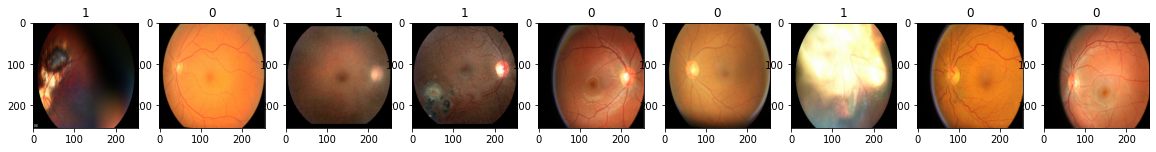

In [16]:
batch = data_iter.next()
fig, ax = plt.subplots(ncols=9, figsize=(20,20))
for idx, img in enumerate(batch[0][:9]):
  ax[idx].imshow(img.astype(int))
  ax[idx].title.set_text(batch[1][idx])

Scale data

In [17]:
data = data.map(lambda x,y: (x/255,y))
scaled_iter = data.as_numpy_iterator()
batch = scaled_iter.next()
print(batch[0].min(),batch[0].max())

0.0 1.0


Split data

In [24]:
nof_batches = len(data)

train_size = int(nof_batches * 0.7)
val_size = int(nof_batches * 0.2) + 1
test_size = int(nof_batches * 0.1) + 1

In [28]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [37]:
IMG_SHAPE = batch[0].shape[-3:]
IMG_SHAPE

(256, 256, 3)

Build the model

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [39]:
model = Sequential()

model.add(
    Conv2D(16, (3,3), 1, activation='relu', input_shape=IMG_SHAPE)
)
model.add(MaxPooling2D())

model.add(
    Conv2D(32, (3,3), 1, activation='relu')
)
model.add(MaxPooling2D())

model.add(
    Conv2D(16, (3,3), 1, activation='relu')
)
model.add(MaxPooling2D())

model.add(Flatten())

model.add(
    Dense(256, activation='relu')
)
model.add(
    Dense(1, activation='sigmoid')
)

In [40]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [41]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 30, 16)      

In [42]:
logdir = '/content/drive/MyDrive/papl_work/logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [55]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
53/53 [==============================] - 133s 2s/step - loss: 0.0535 - accuracy: 0.9876 - val_loss: 0.1205 - val_accuracy: 0.9824
Epoch 2/20
53/53 [==============================] - 139s 3s/step - loss: 0.0560 - accuracy: 0.9870 - val_loss: 0.1019 - val_accuracy: 0.9805
Epoch 3/20
53/53 [==============================] - 130s 2s/step - loss: 0.0503 - accuracy: 0.9900 - val_loss: 0.1215 - val_accuracy: 0.9785
Epoch 4/20
53/53 [==============================] - 140s 3s/step - loss: 0.0604 - accuracy: 0.9876 - val_loss: 0.0853 - val_accuracy: 0.9844
Epoch 5/20
53/53 [==============================] - 146s 3s/step - loss: 0.0606 - accuracy: 0.9876 - val_loss: 0.0799 - val_accuracy: 0.9863
Epoch 6/20
53/53 [==============================] - 213s 4s/step - loss: 0.0548 - accuracy: 0.9870 - val_loss: 0.0690 - val_accuracy: 0.9883
Epoch 7/20
53/53 [==============================] - 129s 2s/step - loss: 0.0490 - accuracy: 0.9882 - val_loss: 0.1093 - val_accuracy: 0.9824
Epoch 8/20
53

Evaluate performance

In [57]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [58]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

for batch in test.as_numpy_iterator():
  X, y = batch
  y_pred = model.predict(X)
  pre.update_state(y, y_pred)
  re.update_state(y, y_pred)
  acc.update_state(y, y_pred)

print(pre.result().numpy(), re.result().numpy(), acc.result().numpy())

1/1 [==============================] - 0s 33ms/step
1.0 0.9375 0.988189


Save model

In [ ]:
from tensorflow.keras.models import load_model
model.save(os.path.join('/content/drive/MyDrive/papl_work/models', 'ot_img_class_acc_94.h5'))